In [1]:
import json
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx

import seaborn as sns
# sns.set(color_codes=True)

import matplotlib.gridspec as gridspec
from scipy.cluster import hierarchy

mpl.style.use('seaborn')
%matplotlib inline

# Loader


In [2]:
#get users and mentions from the download files:
tweets_datas_path = [
                     "cuentas_tweets_10.json"
#                      "cuentas_tweets_8.json",
#                      "cuentas_tweets_7.json",
#                      "cuentas_tweets_6.json",
#                      "cuentas_tweets_5.json"
                    ]
tw_id=[]
tw_user_id=[]
tw_user=[]
tw_text=[]
entities_long=[]
mentioned_ids=[]
tw_device=[]# print(twits[rnd_ind]["source"])
tw_date=[]# print(twits[rnd_ind]["created_at"])


for json_file in tweets_datas_path:
    with open(json_file, "r") as tweets_file:
        for line in tweets_file:
            try:
                tweet = json.loads(line)
                tw_entities=[]
                tw_entities.extend(tweet["entities"]["user_mentions"])
                entities_long.extend(tweet["entities"]["user_mentions"])
                tw_text_loop=[tweet["text"]]
                if tweet["truncated"]:#=="True": # Truncated indica si el tweet es corto o largo; si truncado, busca extendido
                    tw_text_loop=[tweet["extended_tweet"]["full_text"]]
                    tw_entities.extend(tweet["extended_tweet"]["entities"]["user_mentions"])
                    entities_long.extend(tweet["extended_tweet"]["entities"]["user_mentions"])
                else:
                    if tweet["text"][0:2]=="RT":
                        if tweet["retweeted_status"]["truncated"]:
                            tw_text_loop=[tweet["retweeted_status"]["extended_tweet"]["full_text"]]
                            tw_entities.extend(tweet["retweeted_status"]["extended_tweet"]["entities"]["user_mentions"])
                            entities_long.extend(tweet["retweeted_status"]["extended_tweet"]["entities"]["user_mentions"])
                        else: 
                            tw_text_loop=[tweet["retweeted_status"]["text"]]
                            tw_entities.extend(tweet["retweeted_status"]["entities"]["user_mentions"])
                        if tweet["retweeted_status"]["is_quote_status"]:
                            tw_text_loop=[tweet["retweeted_status"]["extended_tweet"]["full_text"]]
                            tw_entities.extend(tweet["retweeted_status"]["quoted_status"]["entities"]["user_mentions"])
                            entities_long.extend(tweet["retweeted_status"]["quoted_status"]["entities"]["user_mentions"])
                    else:
                        tw_text_loop=[tweet["text"]]
                tw_id.append(tweet["id_str"])
                tw_user_id.append(tweet["user"]["id_str"])
                tw_user.append(tweet["user"]["screen_name"])
                mentioned_ids.append([tweet["id_str"],tweet["user"]["id_str"],list(set([ent["id_str"] for ent in tw_entities]))])
                tw_text.append([tweet["id_str"],tw_text_loop[0]])
                tw_device.append(tweet["source"])
                tw_date.append(tweet["created_at"])
            except:
                continue

In [3]:
print("Tweets identificados con código     :",len(tw_id),"\n",
      "Tweets con usuario identificado     :",len(tw_user_id),"\n",
      "Tweets con nombre de usuario        :",len(tw_user),"\n",
      "Textos de tweets recuperados        :",len(tw_text),"\n",
      "Total de Menciones en los tweets    :",len(entities_long),"\n",
      "Tweets con menciones identificadas  :",len(mentioned_ids),"\n",
      "Tweets con dispositivos registrado  :",len(tw_device),"\n",
      "Tweets con fechas registradas       :",len(tw_date),"\n"
     )

Tweets identificados con código     : 225575 
 Tweets con usuario identificado     : 225575 
 Tweets con nombre de usuario        : 225575 
 Textos de tweets recuperados        : 225575 
 Total de Menciones en los tweets    : 1314238 
 Tweets con menciones identificadas  : 225575 
 Tweets con dispositivos registrado  : 225575 
 Tweets con fechas registradas       : 225575 



In [4]:
tw_text=np.array(tw_text)

## tablas de menciones


In [5]:
ments_df=pd.DataFrame([[entit["id_str"],
                        entit["screen_name"],
                        entit["name"]
                       ]for entit in entities_long],
                     columns=["id_str","screen_name","name"])

In [6]:
ments_freq=pd.crosstab(index=ments_df.screen_name, columns="count")
ments_freq=ments_freq.sort_values(by=['count'] , ascending=False)
print("Cuentas mencionadas",ments_freq.shape[0])

Cuentas mencionadas 20572


In [7]:
# Tabla de ocurrencia de menciones por tuit
id_ments=pd.crosstab(np.array([tw_mnt for tw_mntns in mentioned_ids for tw_mnt in tw_mntns[2] ]), columns="count").sort_values(ascending=False, by="count")

In [8]:
top_n=150

In [9]:
ments_ids_top=list(id_ments.index[:top_n])

In [10]:
mntns_top_ocurr=np.array([[cand in tw_mntns[2] for cand in ments_ids_top]for tw_mntns in mentioned_ids])

In [11]:
mntns_top_ocurr.shape

(225575, 150)

In [12]:
names_mnts_top=[]
for usr_id in id_ments.index[:top_n]:
    name=""
    try:
        name=ments_df[ments_df.id_str==usr_id].screen_name.iloc[0]
    except:
        name="Unknown"
#     print(usr_id, name)
    names_mnts_top.append(name)
        
#     print(usr_id,tweets_ids[tweets_ids.tw_user_id==usr_id].tw_user.iloc[0])

In [13]:
# twtxt_ids=[txt_id[0] for txt_id in tw_text] # Id del tuit con el texto
df_mntns_top_ocurr=pd.DataFrame(mntns_top_ocurr,columns=names_mnts_top, index=tw_id)

In [14]:
tweets_ids=pd.DataFrame({"tw_user_id":tw_user_id,"tw_user":tw_user}, index=tw_id)
ids_freqs=pd.crosstab(index=tweets_ids.tw_user, columns="count")
ids_freqs=ids_freqs.sort_values(by=['count'] , ascending=False)["count"]
print("twiteros:",ids_freqs.shape[0])

twiteros: 55840


row_0
<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>                   139743
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>                      47478
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                                      18148
<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>                                 16427
<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>                        2919
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>                       468
<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M2)</a>                                   104
<a href="https://twitterrific.com/ios" rel="nofollow">Twitterrific for iOS</a>                             37
<a href="http://www.facebook.com/twitter" rel="nofollow">Facebook</a>                                      32
<a h

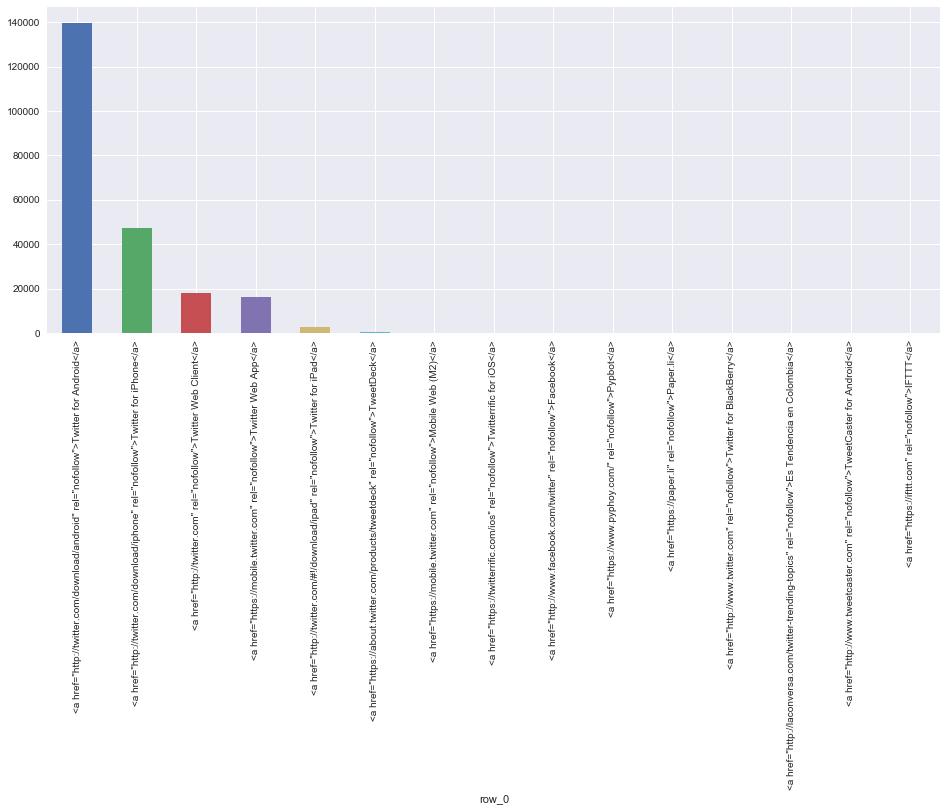

In [15]:
devices=pd.crosstab(index=np.array(tw_device), columns="count")
devices=devices.sort_values(by=['count'] , ascending=False)["count"]
devices[:15].plot(figsize=(16, 6), kind="bar")
devices[:15]

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


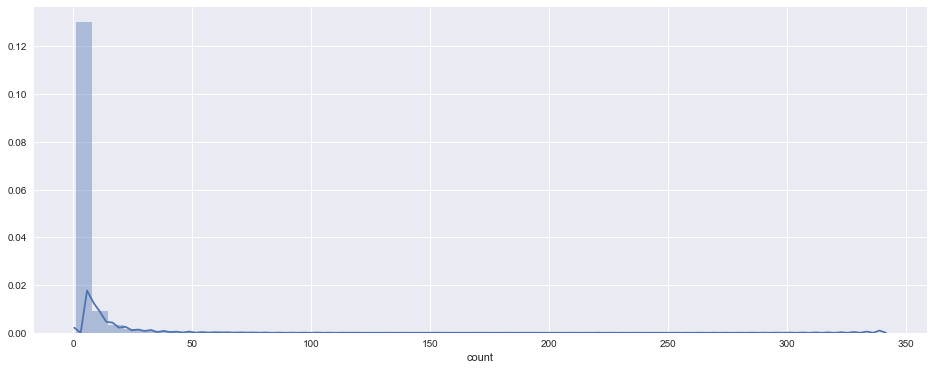

In [16]:
plt.figure(figsize=(16,6))
sns.distplot(ids_freqs)

In [17]:
round(ids_freqs.describe(),3)

count    55840.000
mean         4.040
std          9.012
min          1.000
25%          1.000
50%          1.000
75%          3.000
max        341.000
Name: count, dtype: float64

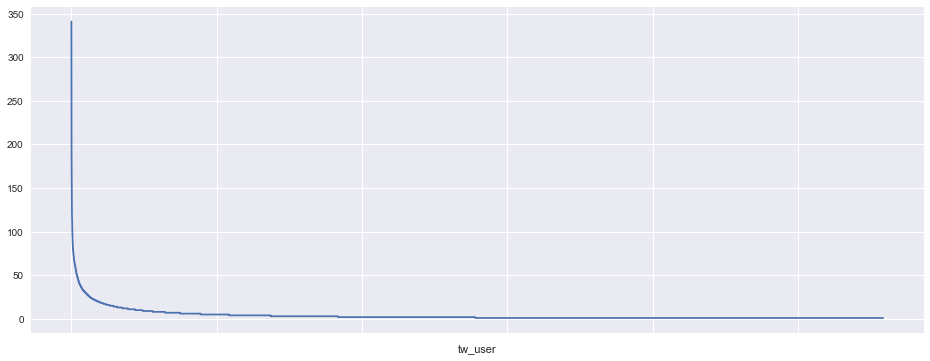

In [18]:
ids_freqs.plot(figsize=(16, 6))

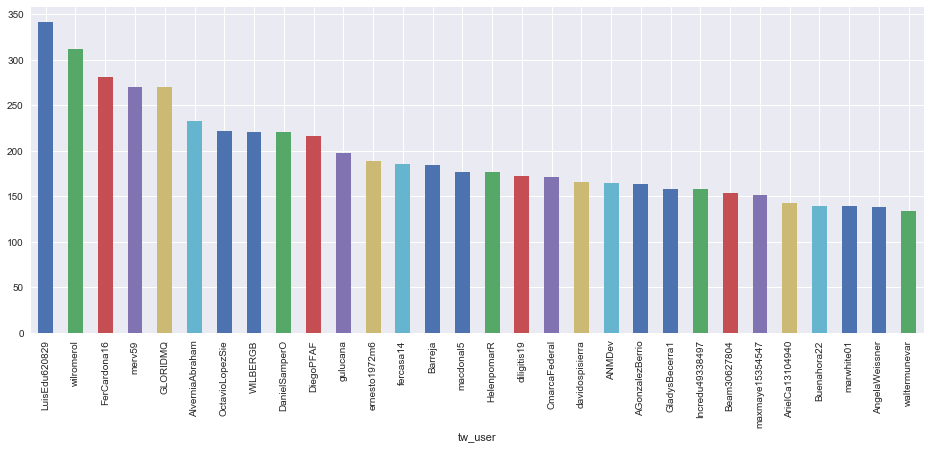

In [19]:
ids_freqs[:30].plot(figsize=(16, 6), kind="bar")
plt.savefig('top_tweeters.png')

In [20]:
ids_freqs.sort_values(ascending=False)[:60]

tw_user
LuisEdu620829      341
wilromerol         311
FerCardona16       281
merv59             270
GLORIDMQ           270
AlverniaAbraham    232
OctavioLopezSie    221
WILBERGB           220
DanielSamperO      220
DiegoPFAF          216
gulucana           197
ernesto1972m6      189
fercasa14          185
Barreja            184
HelenpomarR        176
macdonal5          176
diligitis19        172
CmarcaFederal      171
davidospisierra    166
ANMDev             164
AGonzalezBerrio    163
GladysBecerra1     158
Incredu49338497    158
Beam30627804       154
maxmaye15354547    151
ArielCa13104940    142
Buenahora22        139
marwhite01         139
AngelaWeissner     138
waltermunevar      134
edisonbedoya       133
amparomeza         133
AGtavo1            128
mjrmora            126
SergioGonzalezF    125
TWITERM99417410    123
carlosmaduro9      122
MariaLaurissA      121
sirenita7          121
ed78_75            118
JLR_Amado          117
jsbgm              117
nataliazapata20    116
Sol

In [21]:
uniq_ids=list(set([entit["id_str"]for entit in entities_long]))
len(uniq_ids)

20543

MariaFdaCabal      42885
NanyPardo          28281
DanielSamperO      26957
navarrowolff       26727
ClaudiaLopez       25225
IvanDuque          22001
petrogustavo       20976
angelamrobledo     16163
AngelicaLozanoC    11136
MafeCarrascal       9629
DavidRacero         8353
GustavoBolivar      8274
MartinSantosR       7997
matadoreltiempo     7333
AlvaroUribeVel      7208
Uriasv              7071
ernestomaciast      6745
ArielAnaliza        6681
gener_usuga         5956
IvanCepedaCast      5833
dtype: int64


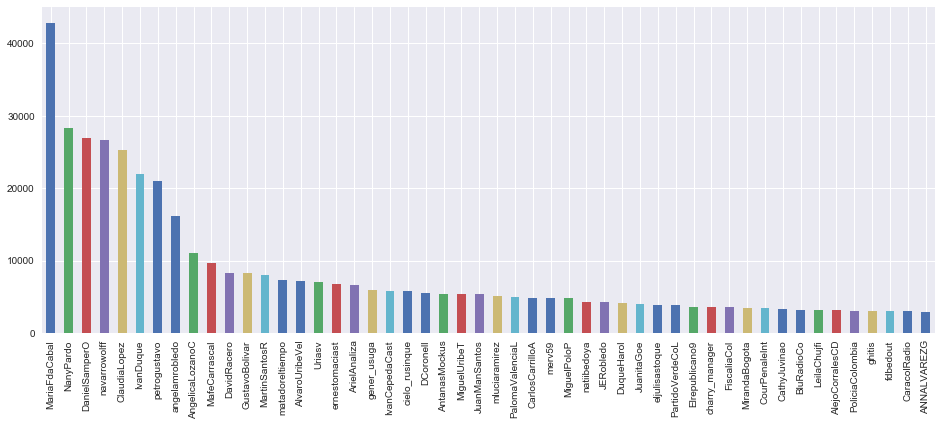

In [22]:
plt.figure(figsize=(16,6))
print (df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False)[:20])
df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False)[:50].plot(kind="bar")
plt.savefig('top_mentions.png')

# Relaciones de cuentas

In [23]:
directed_graph_df=df_mntns_top_ocurr.groupby(tw_user).aggregate(sum)

# Temporalidad

In [24]:
tw_fechas_df=pd.DataFrame(np.column_stack([tw_user,tw_date]))
tw_fechas_df.columns=["user","date_tweet"]
tw_fechas_df["date_tweet"]=pd.to_datetime(tw_fechas_df['date_tweet'], utc=True)#.tz_convert('US/Eastern')
tw_fechas_df.set_index('date_tweet', inplace=True)#.tz_convert('US/Eastern')
tw_fechas_df.index=tw_fechas_df.index.tz_convert('Etc/GMT+5')
tw_fechas_df["ocurr"]=1

In [25]:
time_sample="900S"#"3600s"#'1440T'

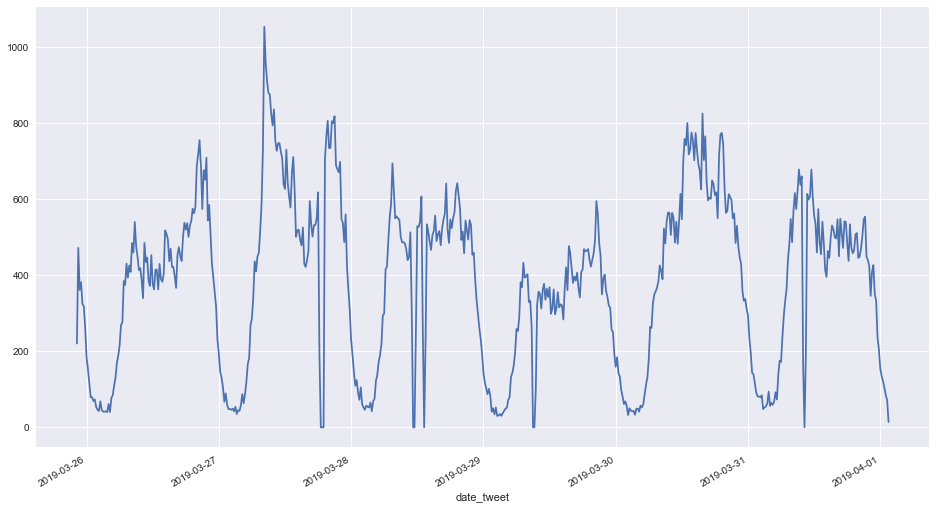

In [26]:
plt.figure(figsize=(16,9))
tw_fechas_df.ocurr.resample(time_sample).sum().plot()#kind="bar")

In [27]:
mayor_tweeters=list(directed_graph_df.sum(axis=1).sort_values(ascending=False).index[:10])

In [28]:
tw_fechas_df_top=tw_fechas_df[tw_fechas_df.user.isin(mayor_tweeters)]
#tw_fechas_df_filt.head(20)

In [29]:
twits_filt=pd.crosstab(index=tw_fechas_df_top.index,
                  columns=tw_fechas_df_top["user"])
twits_filt=twits_filt.resample(time_sample).sum()

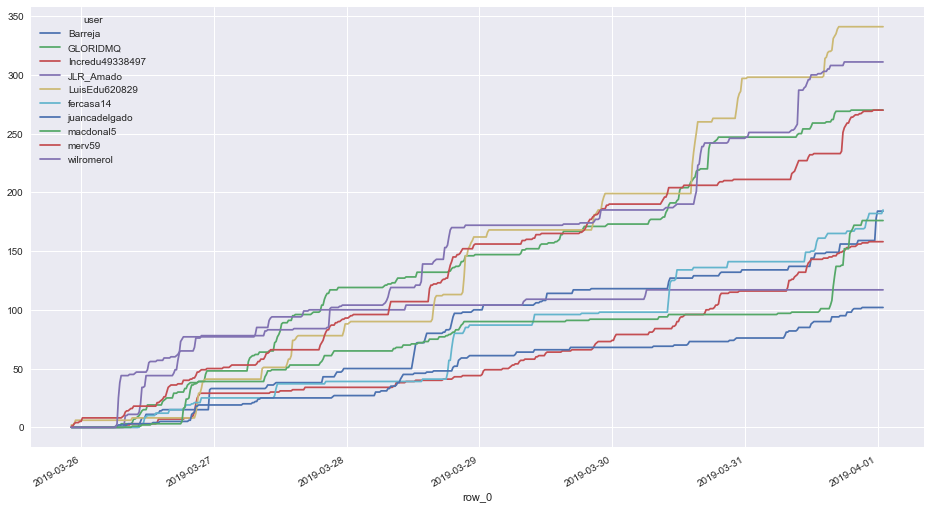

In [30]:
twits_filt.cumsum().plot(figsize=(16,9))

In [31]:
top_ments_df=df_mntns_top_ocurr.copy()*1
top_ments_df.index=tw_fechas_df.index
# top_ments_df.head(20)

In [32]:
top_ments_df_day=top_ments_df.iloc[:,:10].resample(time_sample).sum()

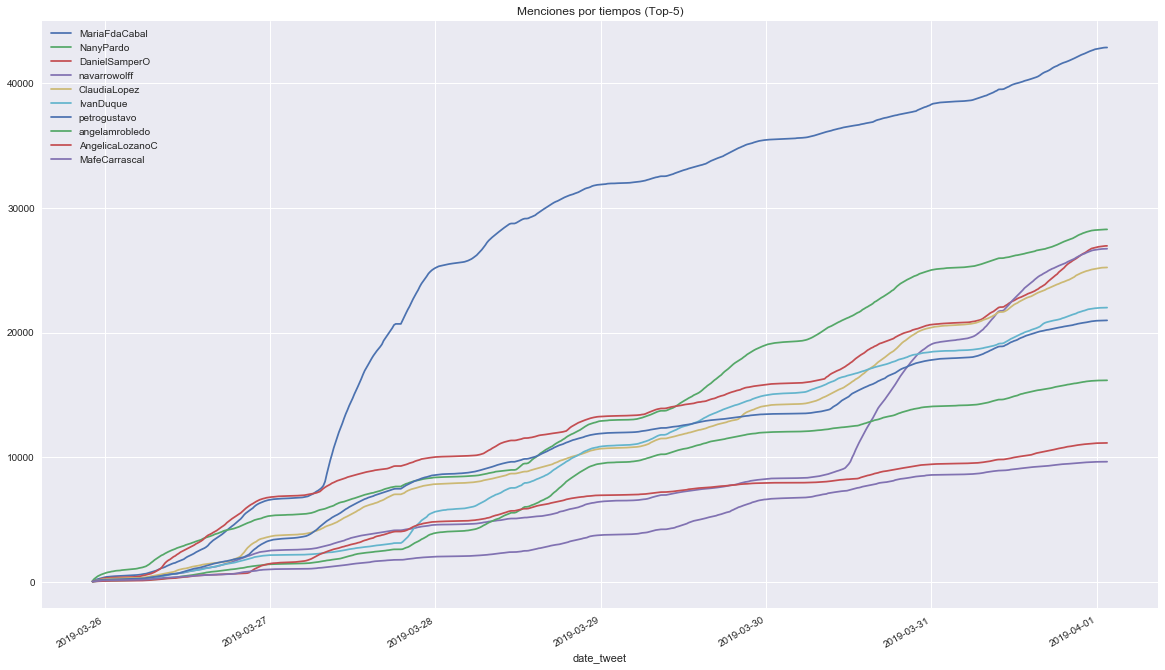

In [33]:
top_ments_df_day.cumsum().plot(figsize=(20,12), title="Menciones por tiempos (Top-5)")

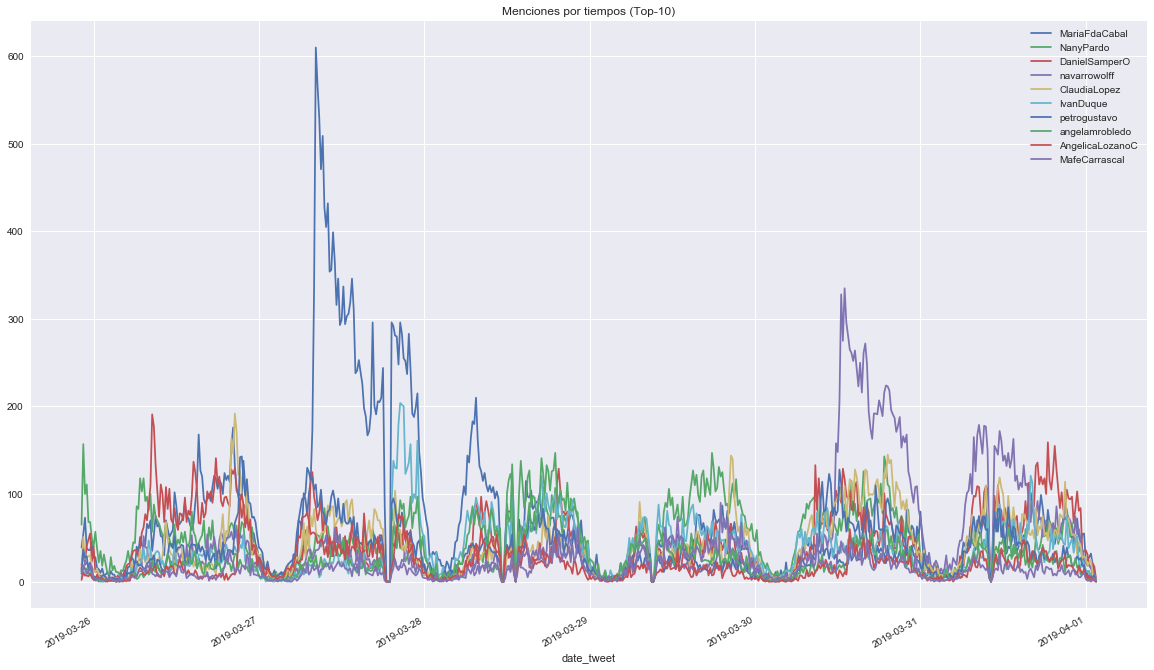

In [34]:
top_ments_df_day.plot(figsize=(20,12), title="Menciones por tiempos (Top-10)")

# Grafos

In [35]:
mat_size=40
graph_mat=directed_graph_df.loc[directed_graph_df.sum(axis=1).sort_values(ascending=False).index[:mat_size],
                                directed_graph_df.sum(axis=0).sort_values(ascending=False).index[:mat_size]
                               ]
graph_mat.head()

,MariaFdaCabal,NanyPardo,DanielSamperO,navarrowolff,ClaudiaLopez,IvanDuque,petrogustavo,angelamrobledo,AngelicaLozanoC,MafeCarrascal,...,natiibedoya,JERobledo,DuqueHarol,JuanitaGoe,eljulisastoque,PartidoVerdeCoL,Elrepublicano9,charry_manager,FiscaliaCol,MirandaBogota
LuisEdu620829,34.0,87.0,56.0,4.0,6.0,55.0,33.0,14.0,4.0,17.0,...,0.0,2.0,2.0,1.0,1.0,8.0,0.0,20.0,2.0,0.0
merv59,48.0,86.0,36.0,4.0,12.0,34.0,44.0,16.0,6.0,19.0,...,0.0,2.0,17.0,0.0,0.0,9.0,0.0,0.0,6.0,3.0
fercasa14,14.0,49.0,27.0,5.0,2.0,46.0,13.0,11.0,0.0,12.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,4.0,8.0,0.0
macdonal5,117.0,17.0,17.0,0.0,2.0,20.0,38.0,13.0,2.0,14.0,...,1.0,2.0,4.0,1.0,1.0,0.0,0.0,1.0,29.0,1.0
GLORIDMQ,26.0,25.0,15.0,28.0,26.0,35.0,54.0,28.0,3.0,17.0,...,3.0,1.0,16.0,8.0,4.0,8.0,0.0,13.0,3.0,3.0


In [36]:
graph_df=graph_mat.melt()
graph_df.columns=["tw_para", "freq"]
graph_df["tw_de"]=[usr for i in range(int(len(graph_df)/len(graph_mat.index)))for usr in list(graph_mat.index)]
graph_df=graph_df.loc[:,["tw_de","tw_para","freq"]]

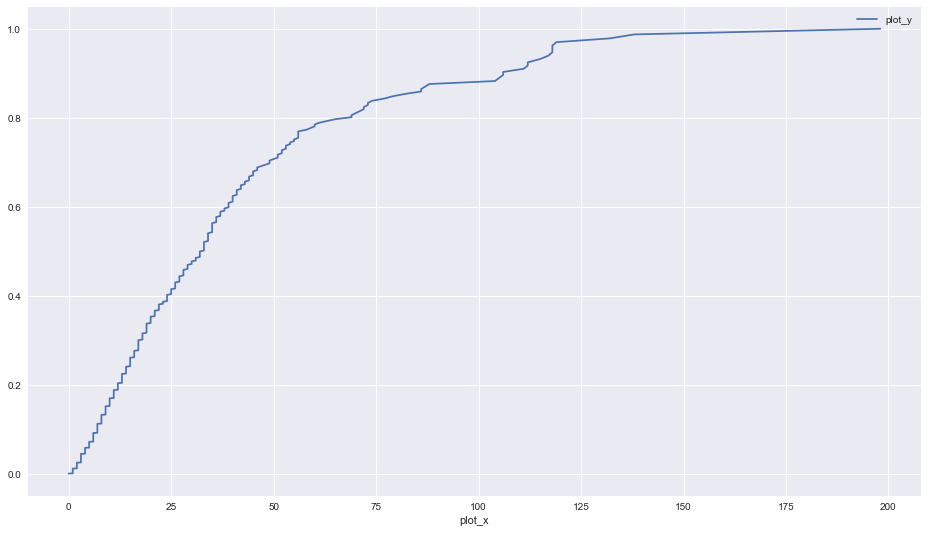

In [37]:
plot_x=np.array(list(graph_df.freq.sort_values(ascending=True)))
plot_y=np.cumsum(plot_x)/sum(plot_x)
cum_freq=pd.DataFrame({"plot_x":plot_x,
                       "plot_y":plot_y})
cum_freq.plot(x="plot_x",
              y="plot_y",
             figsize=(16,9))

In [38]:
min_crit_tw=cum_freq[cum_freq.plot_y>=.5].iloc[0,0]
graph_df_filt=graph_df.loc[graph_df.freq>=min_crit_tw,:]
mx_fr=max(graph_df_filt.freq)
print(min_crit_tw)
print(len(graph_df_filt))
graph_df_filt.sort_values("freq",ascending=False)#.head(20)

33.0
140


,tw_de,tw_para,freq
1121,merv59,merv59,198.0
1123,macdonal5,merv59,138.0
1120,LuisEdu620829,merv59,132.0
137,AGtavo1,navarrowolff,119.0
897,AGtavo1,AntanasMockus,118.0
177,AGtavo1,ClaudiaLopez,118.0
1257,AGtavo1,JERobledo,118.0
3,macdonal5,MariaFdaCabal,117.0
1529,JLR_Amado,FiscaliaCol,115.0
209,JLR_Amado,IvanDuque,112.0


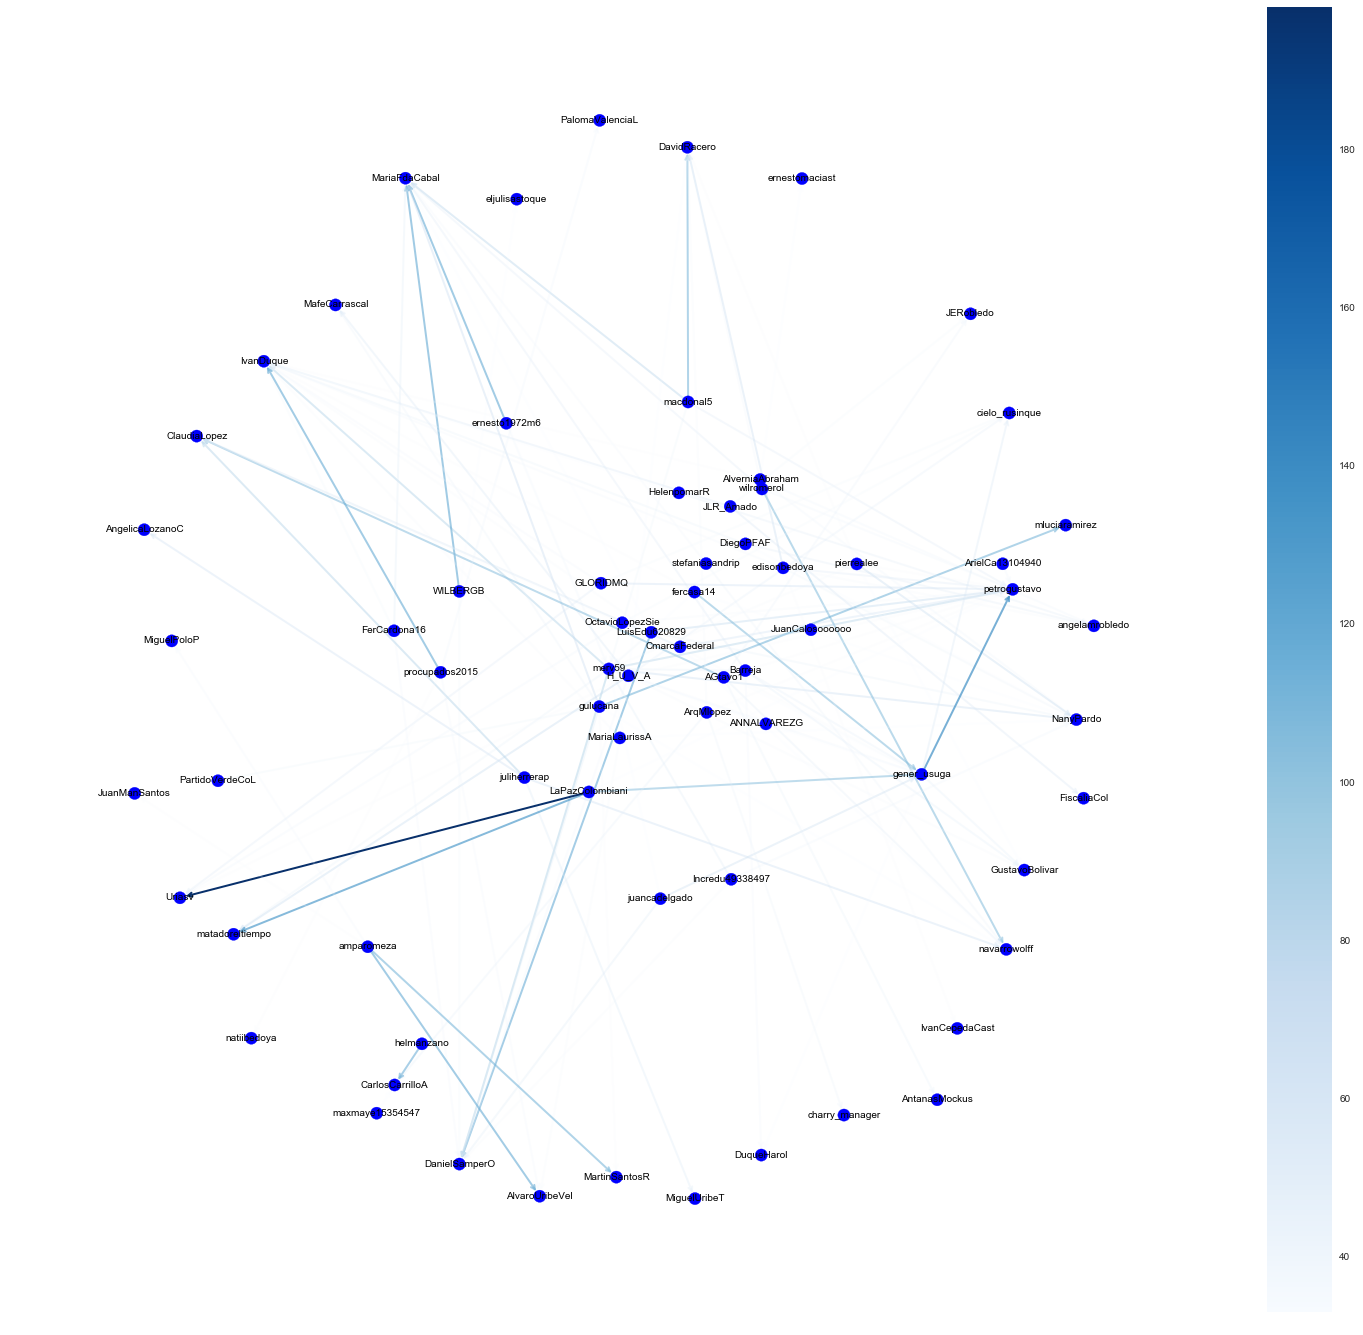

In [39]:
plt.figure(figsize=(26,24))
G= nx.DiGraph()#nx.generators.directed.random_k_out_graph(10, 3, 0.5)
for i, elrow in graph_df_filt.iterrows():
    G.add_edge(elrow[0], elrow[1])

pos = nx.layout.spring_layout(G)

node_sizes = [150 for i in range(len(G))]
M = G.number_of_edges()
edge_colors =[fr for fr in graph_df_filt.freq]#range(2, M + 2)
edge_alphas =[fr/mx_fr for fr in graph_df_filt.freq]#[fr/mx_fr for fr in graph_df_filt.freq]#[(5 + i) / (M + 4) for i in range(M)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue')
edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=10, edge_color=edge_colors,
                               edge_cmap=plt.cm.Blues, width=2)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

nx.draw_networkx_labels(G, pos, font_size=10)

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()

In [40]:
g = nx.Graph()

In [41]:
for i, elrow in graph_df_filt.iterrows():
    g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())

In [42]:
print('# of edges: {}'.format(g.number_of_edges()))
print('# of nodes: {}'.format(g.number_of_nodes()))

# of edges: 140
# of nodes: 69


C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


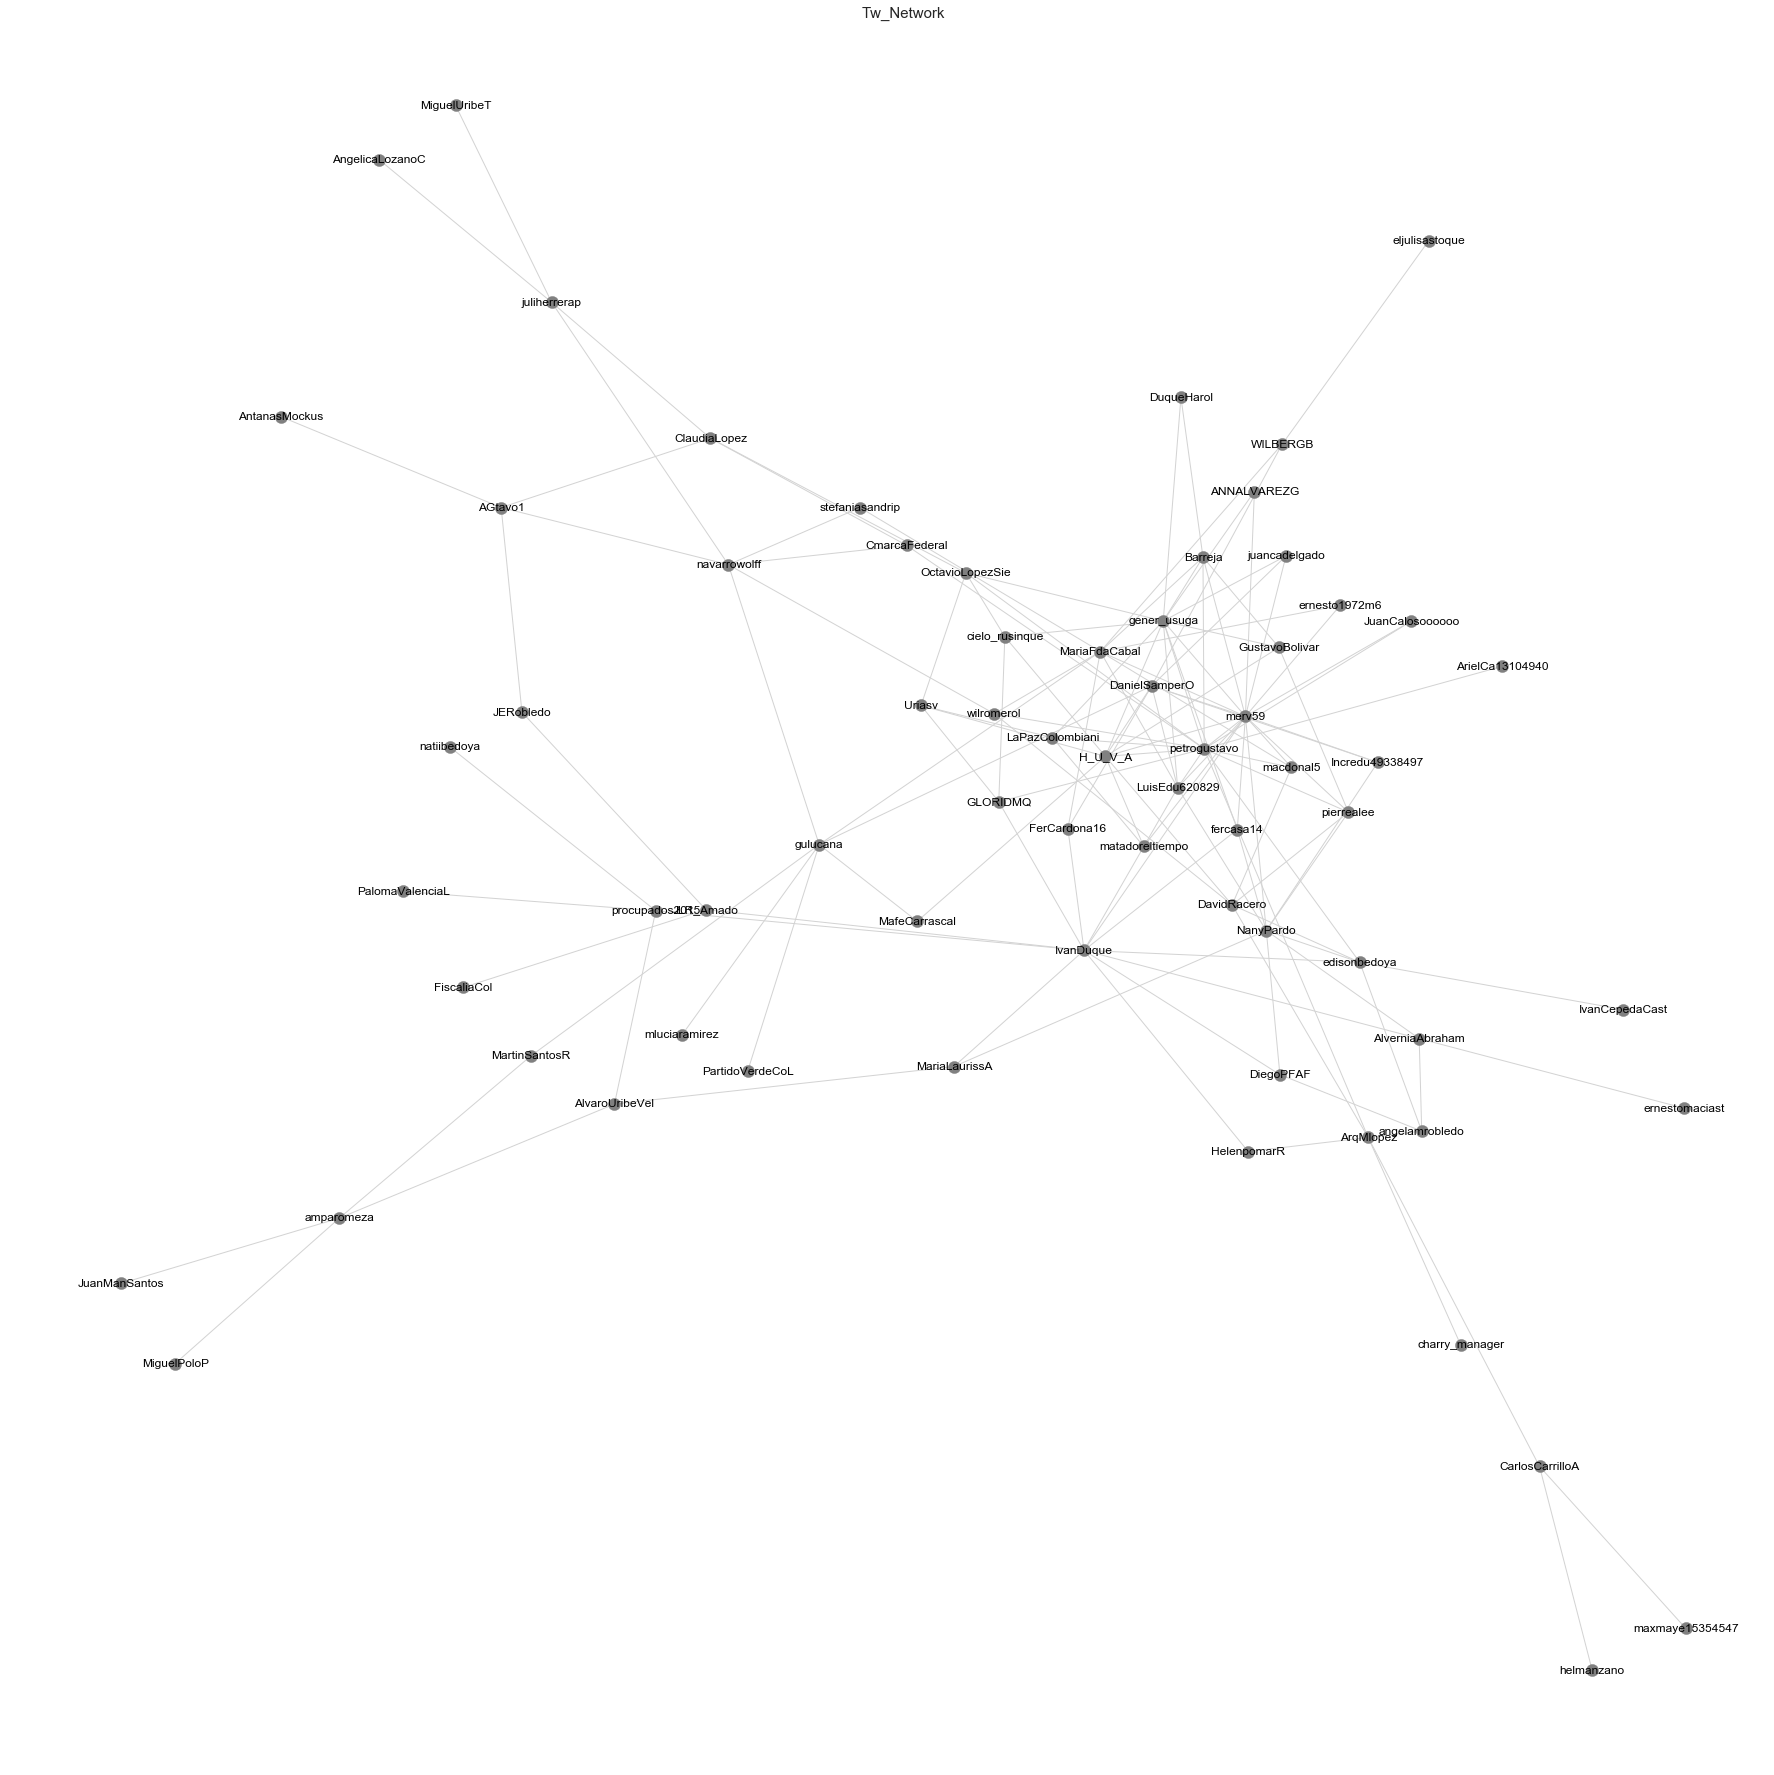

In [43]:
plt.figure(figsize=(24, 24))
nx.draw(g,
        node_size=150,
        edge_color='lightgray',
        node_color='gray',
        with_labels=True)
plt.title('Tw_Network', size=15)
plt.show()
# plt.savefig('tweets_net.png')